In [138]:
# %pip install numpy pandas pillow scikit-learn kagglehub matplotlib ipython
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !conda install -c conda-forge background-generator -y


In [139]:
import os
import pandas as pd
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [140]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA version:", torch.version.cuda)
    print("Device name:", device)
else:
    device = torch.device("cpu")
    print("CUDA is not available")
    print("Device name:", device)


CUDA is not available
Device name: cpu


In [141]:
class Display:
    @staticmethod
    def image_Display(image):
        if torch.is_tensor(image):
            image = image.detach().cpu().numpy()

        if image.ndim == 1:
            image = image.reshape(28,28)

        image = image.astype('uint8')  # ensure proper display format

        display(Image.fromarray(image, mode='L'))


In [142]:
# def convert_merged_csv_to_pt(train_csv_path, test_csv_path, pt_path):
#     dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}
#
#     df_train = pd.read_csv(train_csv_path, dtype=dtype_map, low_memory=False)
#     df_test = pd.read_csv(test_csv_path, dtype=dtype_map, low_memory=False)
#
#     df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42)
#
#     pixel_array = df.drop(columns='label').to_numpy(dtype='float32', copy=True)
#     label_array = df['label'].to_numpy(dtype='int64', copy=True)
#
#     pixels = torch.from_numpy(pixel_array)
#     labels = torch.from_numpy(label_array)
#
#     torch.save((pixels, labels), pt_path)
#     print(f"✅ Saved: {pt_path}")
#
# convert_merged_csv_to_pt("Dataset/mnist_train.csv", "Dataset/mnist_test.csv", "Dataset/mnist.pt")

In [143]:
class Dataset(Dataset):
    def __init__(self, pt_path):
        self.pixels, self.labels = torch.load(pt_path, weights_only=True)

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return self.labels.size(0)

In [144]:
# def benchmark_workers(pt_path="Dataset/mnist.pt", max_workers=12, batch_size=512):
#     dataset = Dataset(pt_path)
#     indices = np.arange(len(dataset))
#     train_idx, _ = train_test_split(indices, test_size=0.2, shuffle=True)
#     train_set = Subset(dataset, train_idx)
#
#
#     for nw in range(max_workers + 1):
#         loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
#                                              num_workers=nw, pin_memory=True,
#                                              persistent_workers=(nw > 0))
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t0 = time.perf_counter()
#
#         for x, y in loader:
#             pass  # simulate one epoch
#
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t1 = time.perf_counter()
#         print(f"num_workers={nw:<2} | time: {t1 - t0:.3f} sec")
#
# benchmark_workers()

In [145]:
class Dataloaders:
    def __init__(self, dataset_cls):
        self.dataset_cls = dataset_cls

    def get(self, pt_path, batch_size=None, test_size=0.09, num_workers=0):
        dataset = self.dataset_cls(pt_path)

        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=True)

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)

        effective_batch_size = len(train_set) if batch_size is None else batch_size

        train_loader = DataLoader(train_set, batch_size=effective_batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  persistent_workers=(num_workers > 0))

        test_loader = DataLoader(test_set, batch_size=len(test_set) if batch_size is None else batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True,
                                 persistent_workers=(num_workers > 0))

        return train_loader, test_loader


In [146]:
# from google.colab import drive
# drive.mount('/content/drive')

In [147]:
loaders = Dataloaders(Dataset)

train_loader, test_loader = loaders.get("/content/drive/MyDrive/Dataset/mnist.pt", batch_size=None)

for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    print(x.shape, y.shape)
    break


torch.Size([63700, 784]) torch.Size([63700])


In [148]:
class Scaling(nn.Module):
    def __init__(self, input_tensor: torch.Tensor, bounds=(0.0, 255.0)):
        super().__init__()

        self.device = input_tensor.device
        self.input_dtype = input_tensor.dtype

        min_val = input_tensor.min()
        max_val = input_tensor.max()

        lower, upper = map(float, bounds)
        delta_mm = max_val - min_val
        delta_ul = upper - lower

        a = delta_mm + delta_ul
        b = lower * delta_mm + min_val * delta_ul
        c = 2 * delta_mm * delta_ul

        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer("c", c)

    def forward(self, input_tensor: torch.Tensor):
        if self.c == 0: return input_tensor
        return (self.a * input_tensor - self.b) / self.c

    @torch.no_grad()
    def inverse(self, scaled_tensor: torch.Tensor):
        if self.c == 0: return scaled_tensor
        return (self.c * scaled_tensor + self.b) / self.a


In [149]:
class Classifier(nn.Module):
    def __init__(self, categories: int):
        super().__init__()
        self.categories = categories

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        return F.one_hot(labels.view(-1), num_classes=self.categories).float()

    @torch.no_grad()
    def inverse(self, one_hot_tensor: torch.Tensor) -> torch.Tensor:
        return one_hot_tensor.argmax(dim=1, keepdim=True)


In [150]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)


    print(x.shape, y.shape)
    break

torch.Size([63700, 784]) torch.Size([63700])


In [151]:
#----
#Global dictionary to hold activations for current epoch
current_epoch_activations = {}

# Per-epoch neuron value store
all_epoch_activations = []  # List of dicts

# Hook function
def get_activation(name):
    def hook(model, input, output):
        if name not in current_epoch_activations:
            current_epoch_activations[name] = []
        current_epoch_activations[name].append(output.detach().cpu())  # Collect batch output
    return hook

#----

In [152]:
for layer_name, batch_outputs in current_epoch_activations.items():
    print(f"Layer: {layer_name}")
    for i, tensor in enumerate(batch_outputs):
        print(f"  Batch {i}: shape = {tensor.shape}")


In [153]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_sizes = [784, 121, 25, 10]
        self.net = nn.Sequential(
            nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True),
            nn.Sigmoid(),                       # fused activation
            nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True),
            nn.ReLU(inplace=True),              # in‑place
            nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True),
            nn.Softmax(dim=1)
        )

        nn.init.xavier_uniform_(self.net[0].weight)
        nn.init.uniform_(self.net[0].bias, -1.0/math.sqrt(self.layer_sizes[0]), 1.0/math.sqrt(self.layer_sizes[0]))
        nn.init.kaiming_normal_(self.net[2].weight, nonlinearity='relu')
        nn.init.uniform_(self.net[2].bias, -1.0/math.sqrt(self.layer_sizes[1]), 1.0/math.sqrt(self.layer_sizes[1]))
        nn.init.xavier_normal_(self.net[4].weight)
        nn.init.uniform_(self.net[4].bias, -1.0/math.sqrt(self.layer_sizes[2]), 1.0/math.sqrt(self.layer_sizes[2]))

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.contiguous()
        return self.net(x)

In [154]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)
    net = NN().to(device, non_blocking=True)

    x_scaled = Scaling1(x)
    y_encoded = Classifier1(y)

    yHAT = net(x_scaled)
    loss = net.loss_fn(yHAT, y)
    print("CrossEntropy Loss:", loss.item())


    print(x_scaled.shape, y_encoded.shape, yHAT.shape)
    break


CrossEntropy Loss: 2.3040719032287598
torch.Size([63700, 784]) torch.Size([63700, 10]) torch.Size([63700, 10])


In [155]:
class UltraFastTrainer:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer_cls=torch.optim.Adam,
        lr=1e-3,
        max_epochs=50,
        clip_grad_norm=1.0,
        use_amp=True,
        use_tqdm=False,
        save_path=None
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer_cls(model.parameters(), lr=lr)
        self.max_epochs = max_epochs
        self.clip_grad_norm = clip_grad_norm
        self.use_amp = use_amp
        self.save_path = save_path
        self.use_tqdm = use_tqdm

        self.scaler_amp = GradScaler(enabled=use_amp)
        self.loss_history = []

    def _prefetch_loader(self, loader):
        for x, y in loader:
            yield x.to(device, non_blocking=True), y.to(device, non_blocking=True)

    def train(self, train_loader):
        self.model.train()

        x_sample, _ = next(iter(train_loader))
        scaler = Scaling(x_sample.to(device))

        for epoch in range(1, self.max_epochs + 1):
            start = time.perf_counter()
            total_loss = 0.0
            #-----
            global current_epoch_activations
            current_epoch_activations = {}  # Reset here
            #-----
            iterable = self._prefetch_loader(train_loader)
            if self.use_tqdm:
                iterable = tqdm(iterable, desc=f"Epoch {epoch}", leave=False)

            for x, y in iterable:
                x = scaler(x)
                #----
                if 'input' not in current_epoch_activations:
                  current_epoch_activations['input'] = []
                current_epoch_activations['input'].append(x.detach().cpu())
                #----
                self.optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=device.type, enabled=self.use_amp):
                    y_pred = self.model(x)
                    loss = self.loss_fn(y_pred, y)

                self.scaler_amp.scale(loss).backward()

                if self.clip_grad_norm:
                    self.scaler_amp.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)

                self.scaler_amp.step(self.optimizer)
                self.scaler_amp.update()

                total_loss += loss.item()
            #------
            # ✅ Moved here: after the whole epoch
            epoch_result = {
                layer_name: torch.cat(outputs, dim=0)
                for layer_name, outputs in current_epoch_activations.items()
            }

            all_epoch_activations.append(epoch_result)

            print(f"\n[Epoch {epoch}] Activation shapes:")
            for name, val in epoch_result.items():
                print(f"  {name}: {val.shape}")
            #------
            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            elapsed = time.perf_counter() - start
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")

        if self.save_path:
            torch.save(self.model.state_dict(), self.save_path)


    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0

        scaler = Scaling(next(iter(test_loader))[0].to(device))

        with torch.no_grad():
            for x, y in self._prefetch_loader(test_loader):
                x = scaler(x)
                pred = self.model(x).argmax(dim=1)
                correct += (pred == y.view(-1)).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")
        return acc

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



[Epoch 1] Activation shapes:
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 001 | Loss: 2.3061 | Time: 7.93s

[Epoch 2] Activation shapes:
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 002 | Loss: 2.2985 | Time: 7.27s

[Epoch 3] Activation shapes:
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 003 | Loss: 2.2919 | Time: 7.13s

[Epoch 4] Activation shapes:
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 004 | Loss: 2.2859 | Time: 7.08s

[Epoch 5] Activation shapes:
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700,

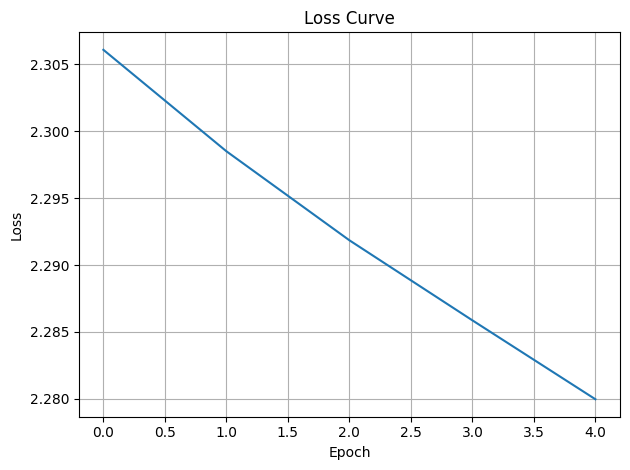

In [156]:
model = NN()
#----
for idx, layer in enumerate(model.net):
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(get_activation(f"layer_{idx}"))

#----

trainer = UltraFastTrainer(model, nn.CrossEntropyLoss(), max_epochs=5, use_amp=True)

trainer.train(train_loader)
trainer.evaluate(test_loader)
trainer.plot_loss()


In [160]:
all_epoch_activations

[{'input': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'layer_0': tensor([[ 0.3184, -0.0562,  0.1196,  ..., -0.2891, -0.0845,  0.1465],
          [-0.1602, -0.0913, -0.1797,  ...,  0.4512, -0.7188,  0.6055],
          [-0.0767, -0.1738, -0.6602,  ...,  0.6875, -0.8750, -0.2871],
          ...,
          [ 0.2539,  0.0850,  0.2100,  ...,  0.1729, -0.4004,  0.5156],
          [ 0.7812,  0.3223, -0.3496,  ...,  0.6992, -0.3184,  0.1602],
          [ 0.3223,  0.2207, -0.6133,  ..., -0.0603, -0.6094, -0.8711]],
         dtype=torch.bfloat16),
  'layer_2': tensor([[0.3457, 0.4805, 0.0000,  ..., 0.0000, 0.6641, 0.0000],
          [0.3535, 0.0000, 0.0000,  ..., 0.0000, 0.8945, 0.0000],
          [0.4316, 0.3770, 0.0000,  ..., 0.0000, 0.7188, 0.0000],
          ...,
       

In [158]:
print(f"\nTotal epochs stored: {len(all_epoch_activations)}")
for epoch_idx, data in enumerate(all_epoch_activations):
    print(f"Epoch {epoch_idx + 1}")
    for layer_name, tensor in data.items():
        print(f"  {layer_name}: {tensor.shape}")



Total epochs stored: 5
Epoch 1
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 2
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 3
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 4
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 5
  input: torch.Size([63700, 784])
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])


In [159]:
len(all_epoch_activations)

5

In [173]:
'input' in all_epoch_activations[0]

True

Visualisation of the stored data

In [223]:
import matplotlib.pyplot as plt

def show_activation_grid(activation_dict, sample_idx):
    layer_shapes = {
        'input': (28, 28),
        'layer_0': (11, 11),
        'layer_2': (5, 5),
        'layer_4': (1, 10)
    }

    num_layers = len(layer_shapes)
    plt.figure(figsize=(10, 2.5))

    for i, (layer_name, shape) in enumerate(layer_shapes.items()):
        activation = activation_dict[layer_name][sample_idx]

        # ✅ Convert to float32 before reshaping and plotting
        activation = activation.to(torch.float32).numpy().reshape(shape)
        plt.suptitle(f"Epoch Index = {epoch_idx}, Sample Index = {sample_idx}")
        plt.subplot(1, num_layers, i + 1)
        plt.imshow(activation, cmap='gray')
        plt.title(layer_name)

        plt.axis('off')


    plt.tight_layout()
    plt.show()

In [224]:

epoch_idx = 4    # Which epoch to visualize
sample_idx = 63699     # Which sample (out of 63700) to visualize


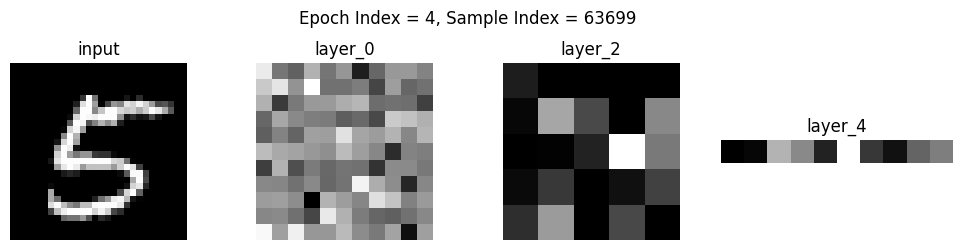

In [225]:
# Add this in your notebook/script after training
show_activation_grid(all_epoch_activations[epoch_idx], sample_idx)


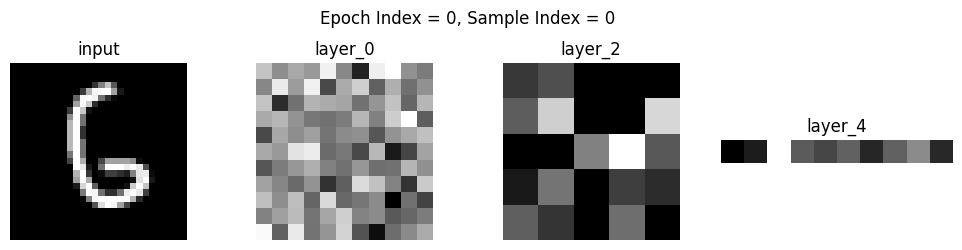

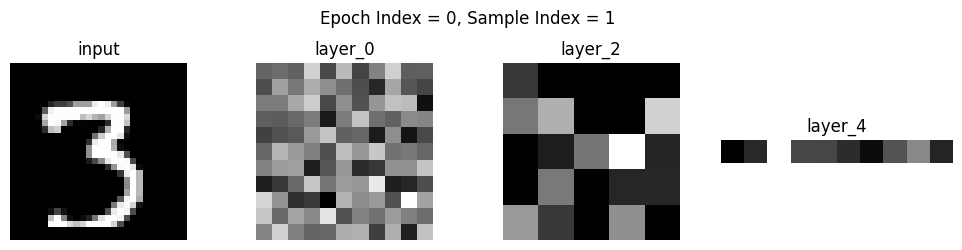

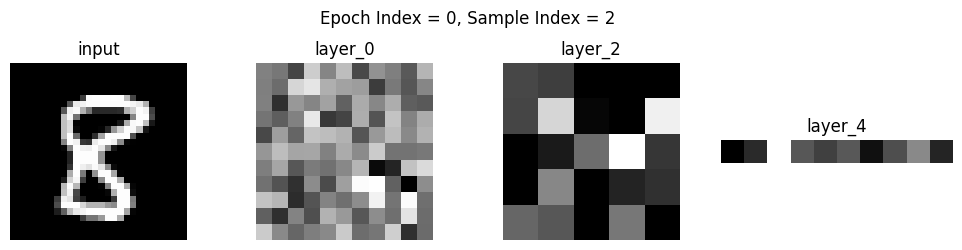

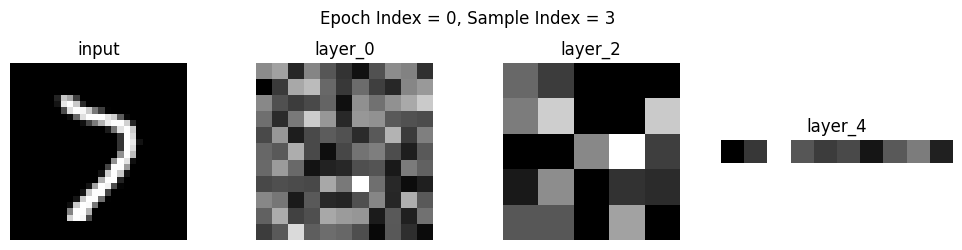

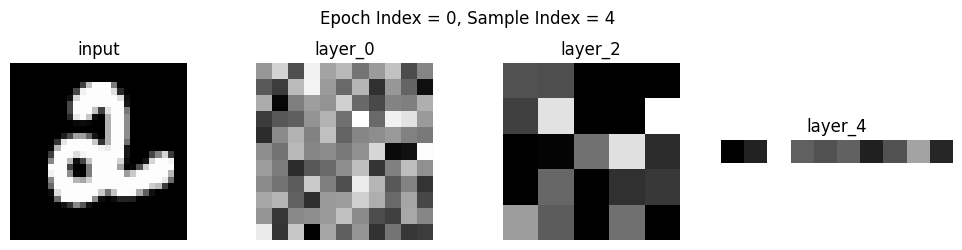

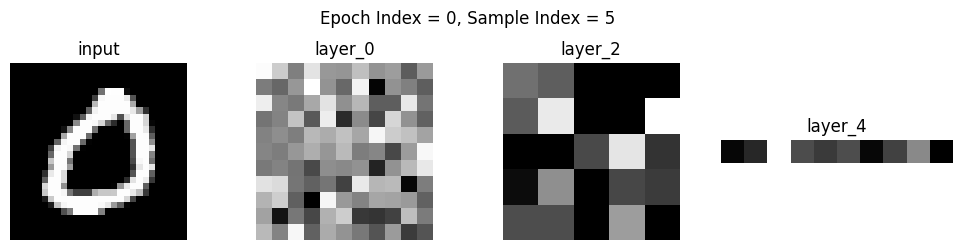

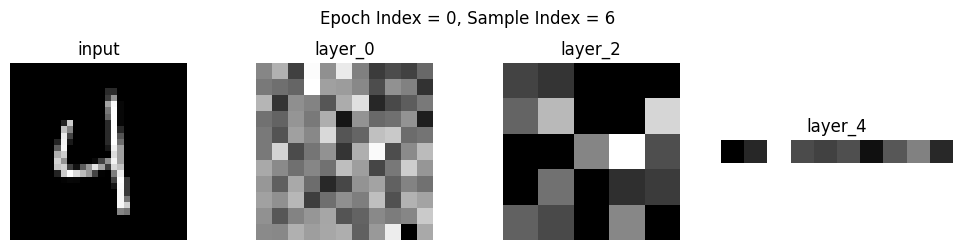

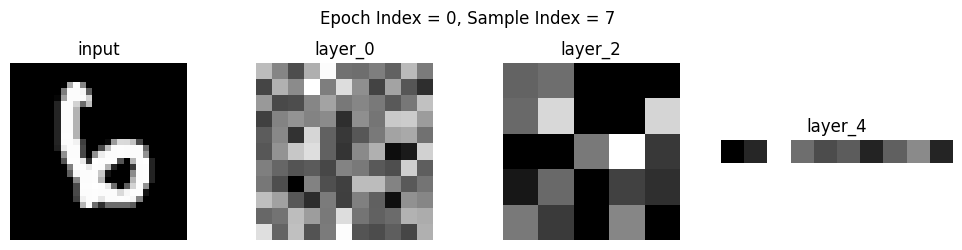

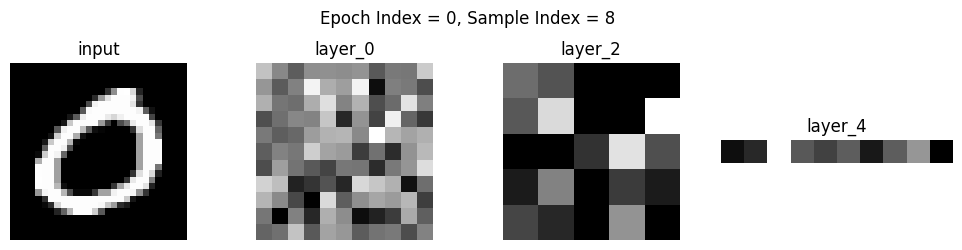

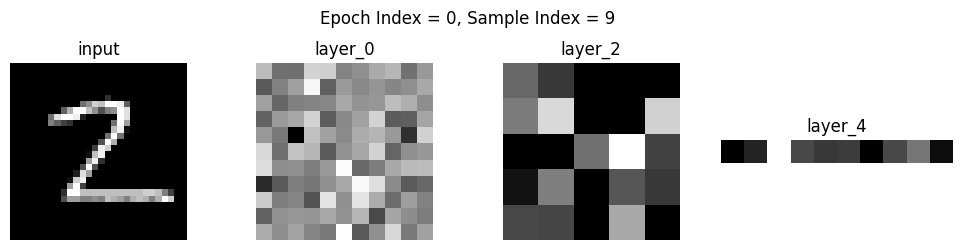

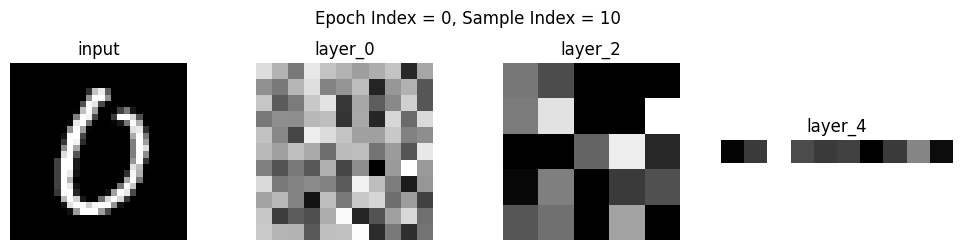

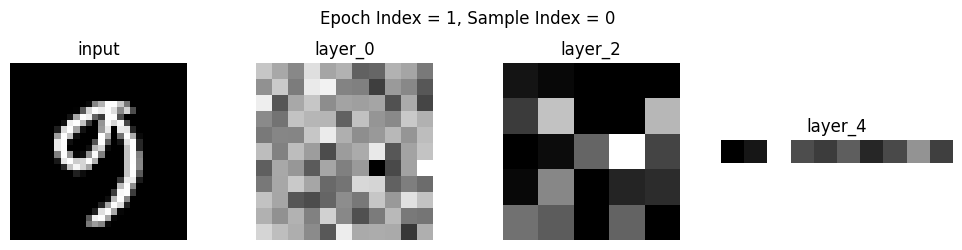

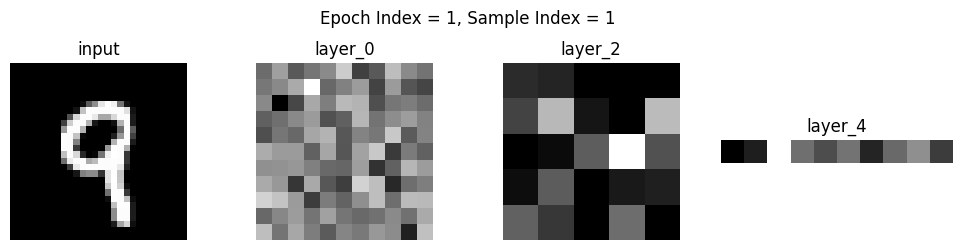

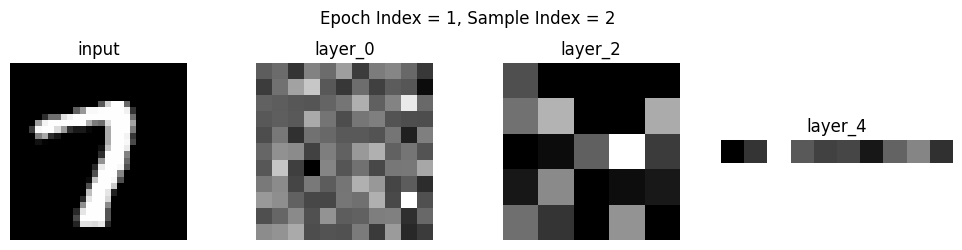

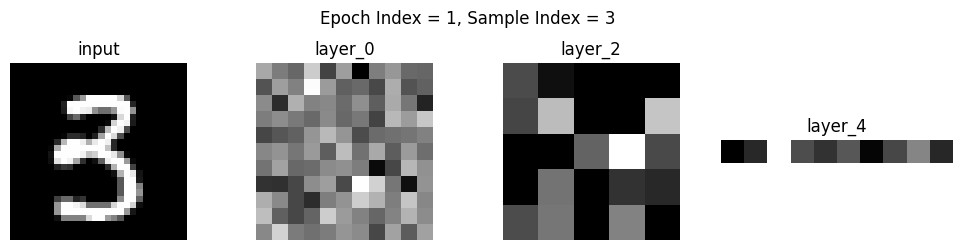

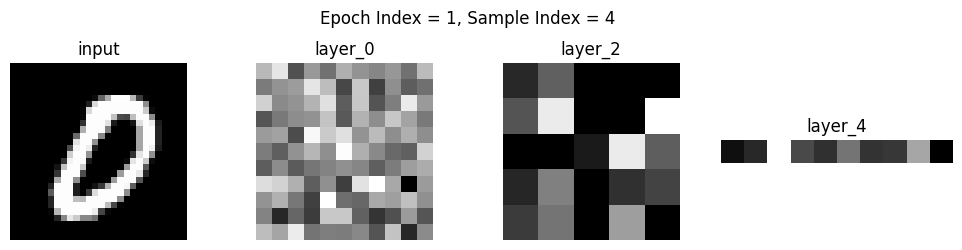

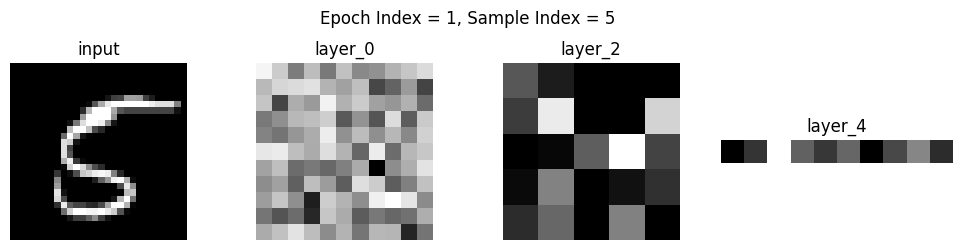

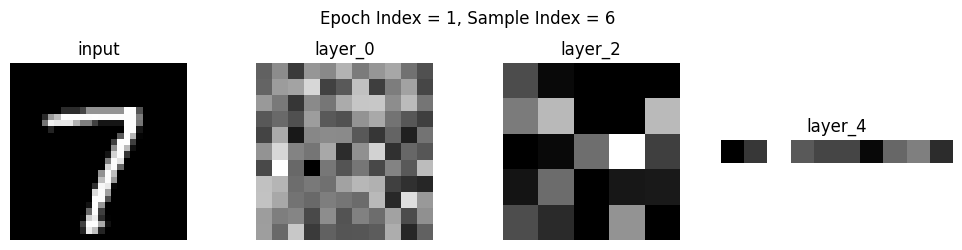

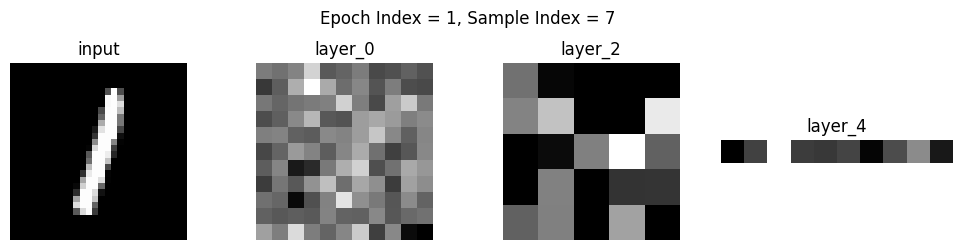

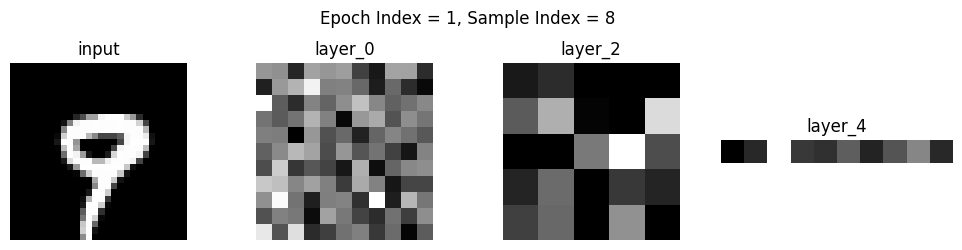

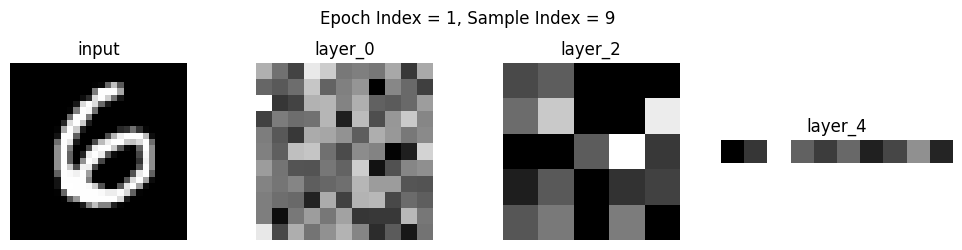

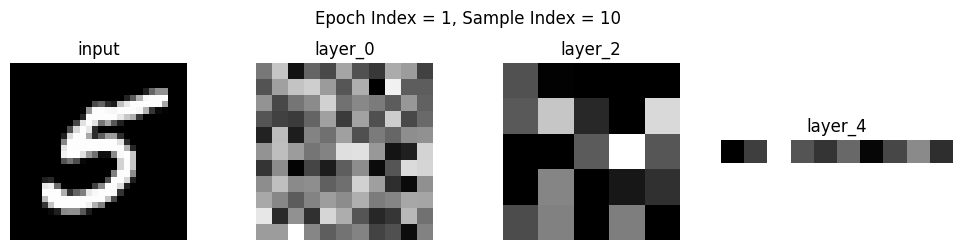

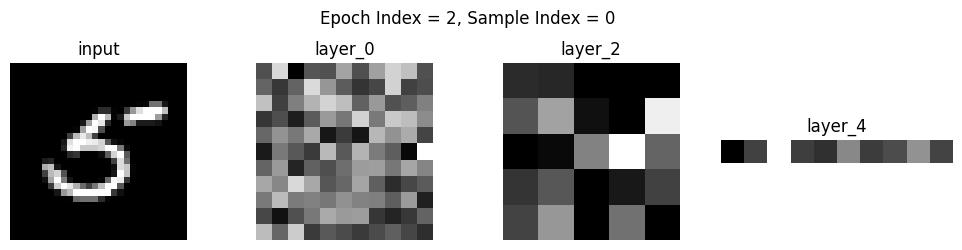

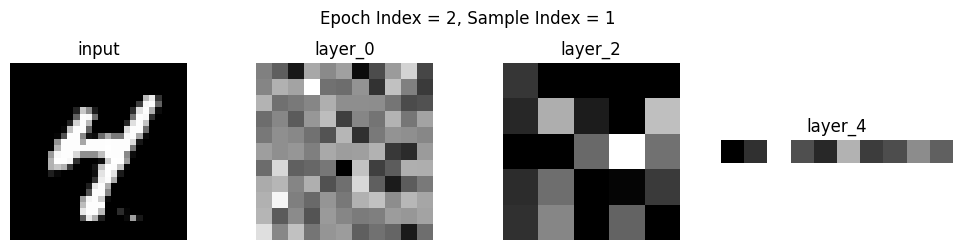

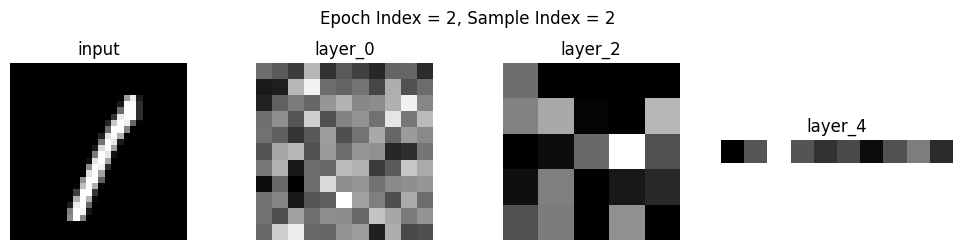

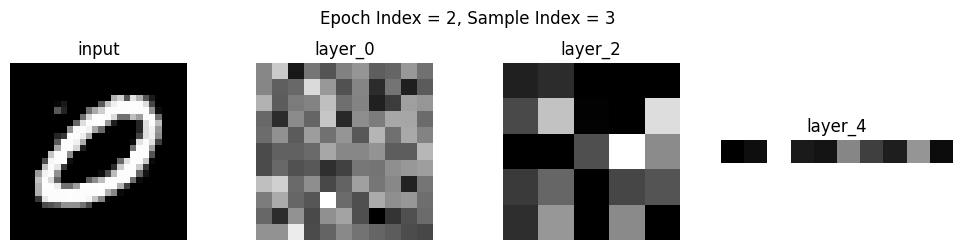

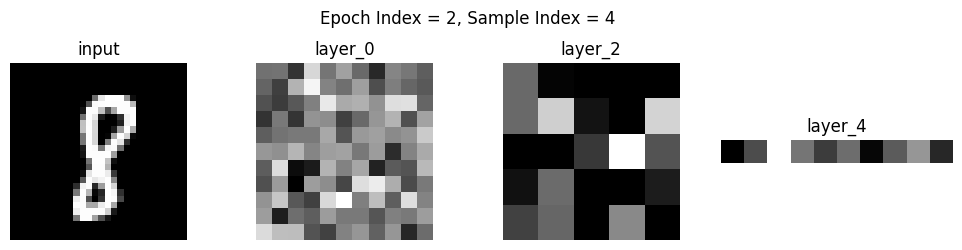

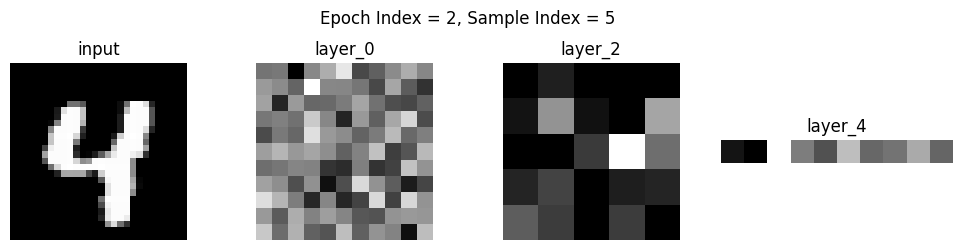

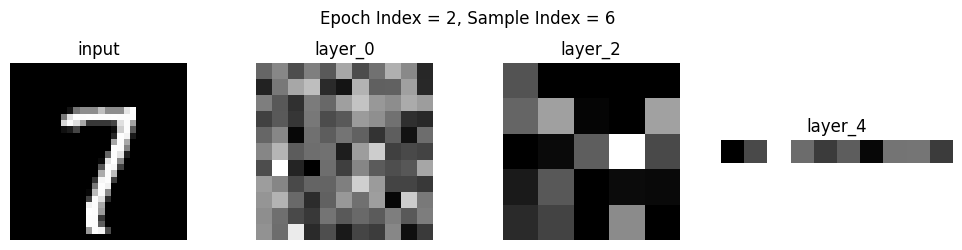

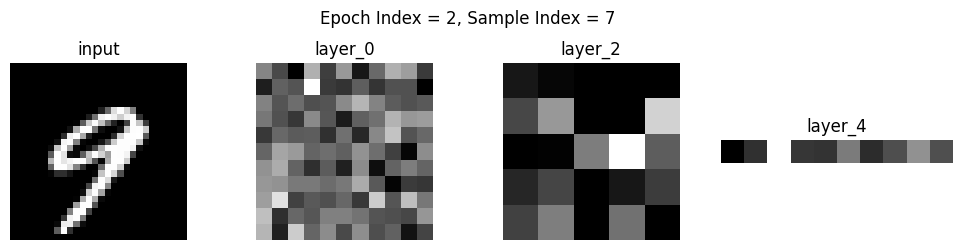

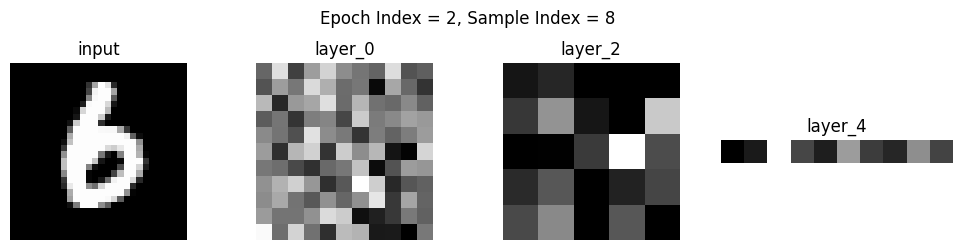

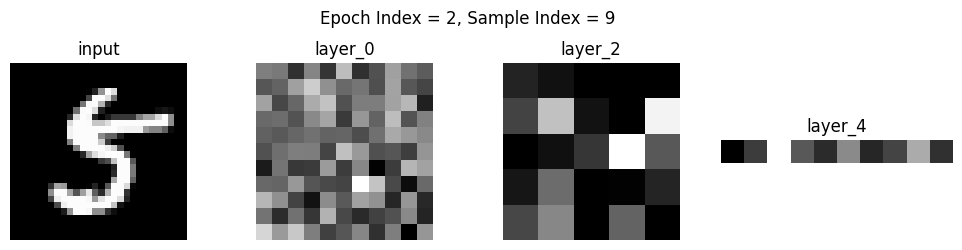

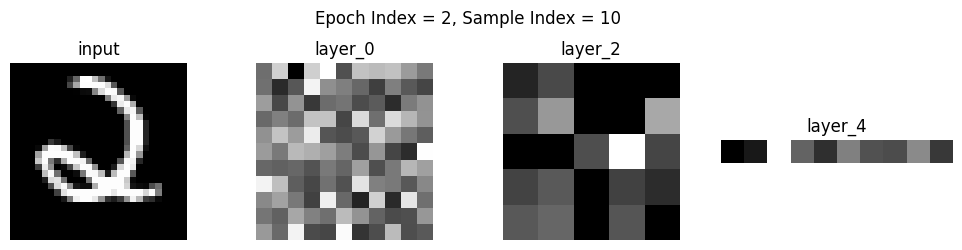

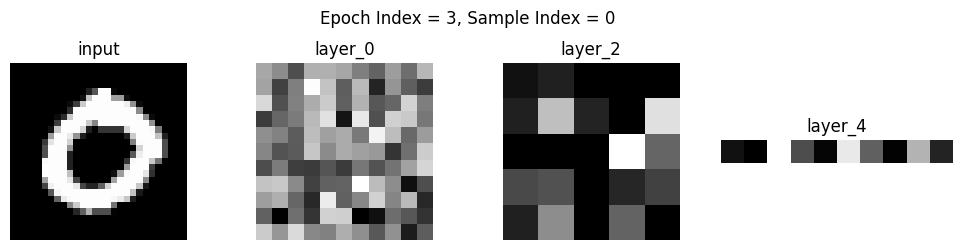

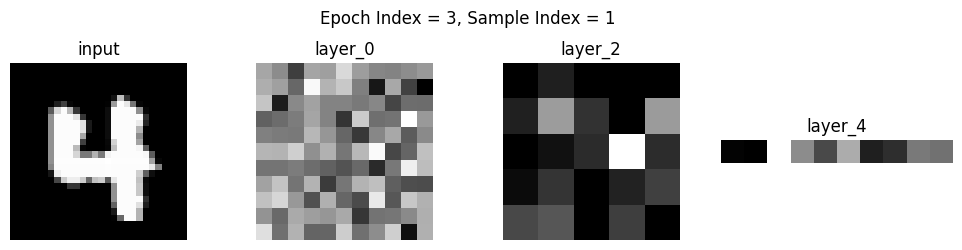

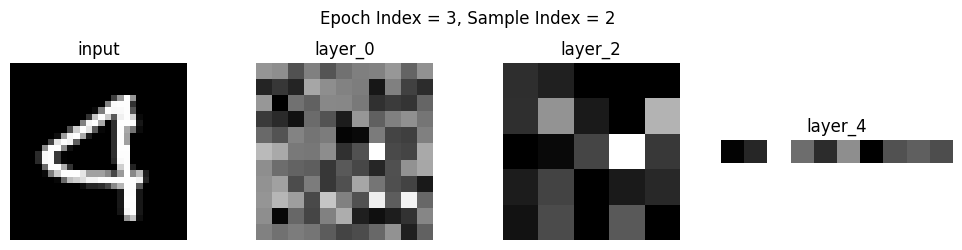

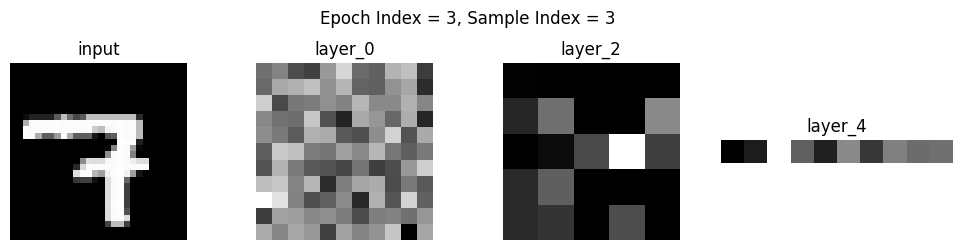

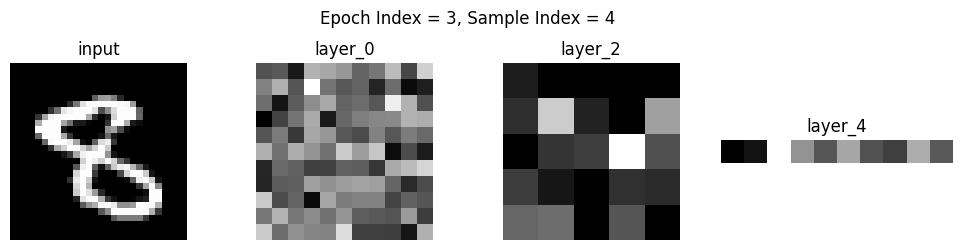

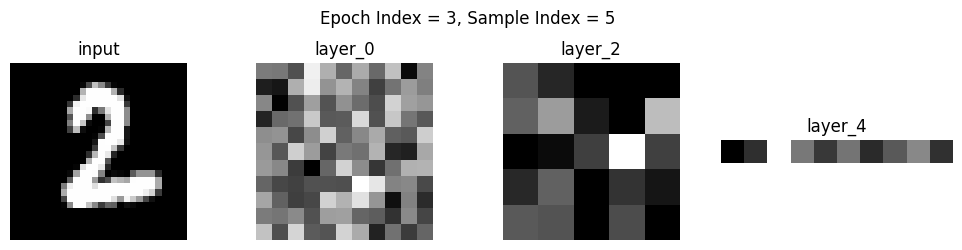

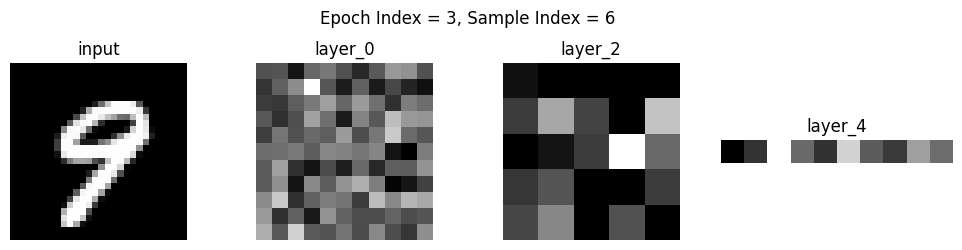

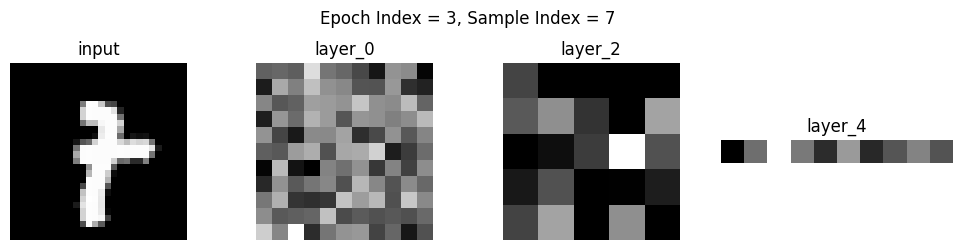

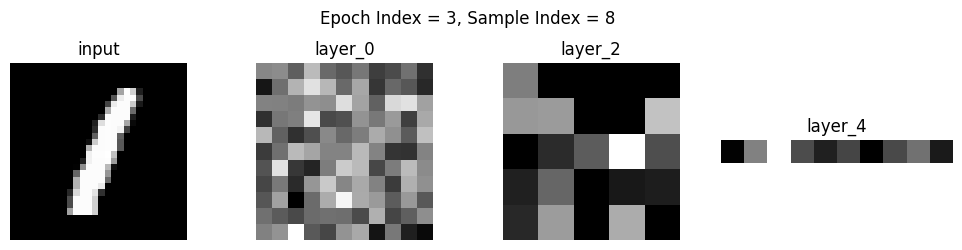

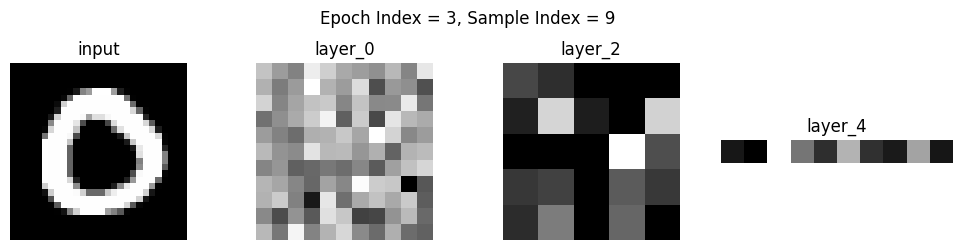

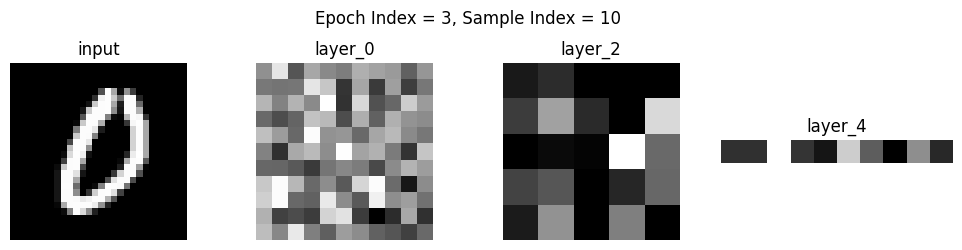

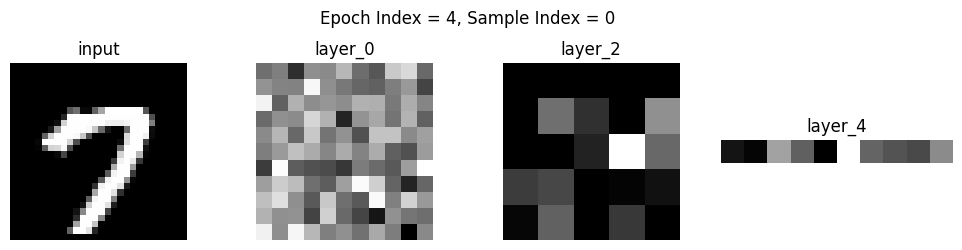

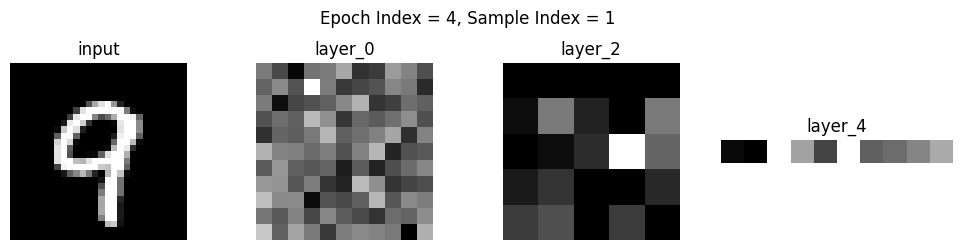

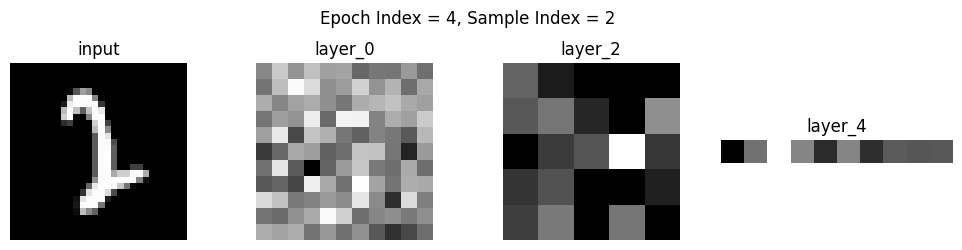

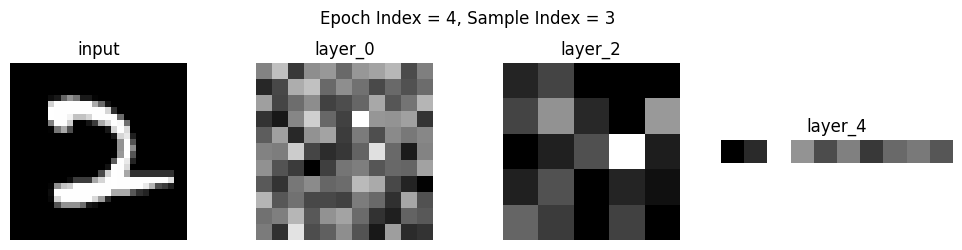

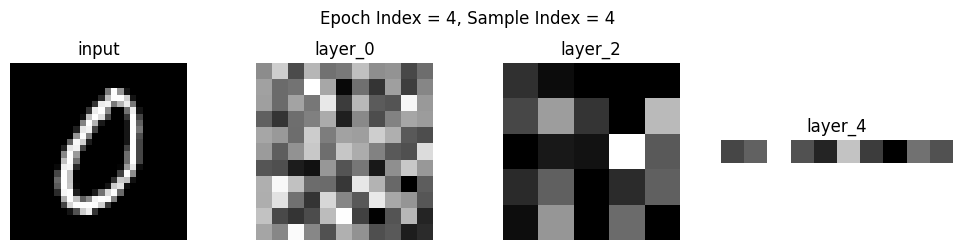

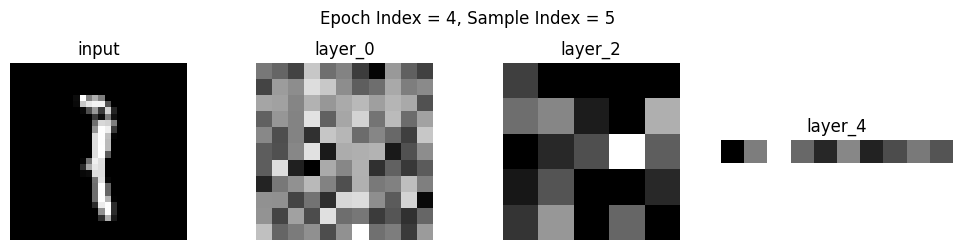

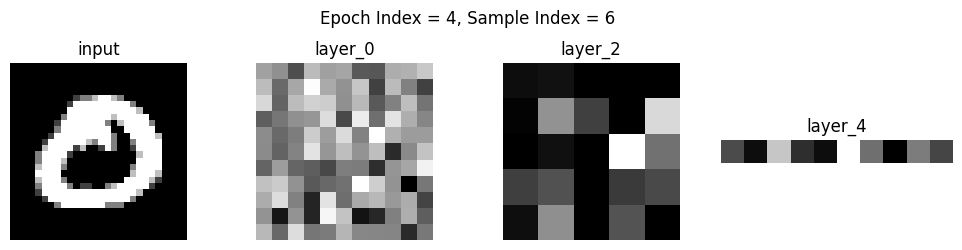

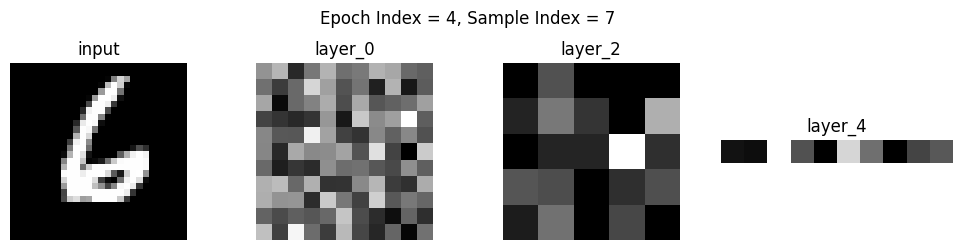

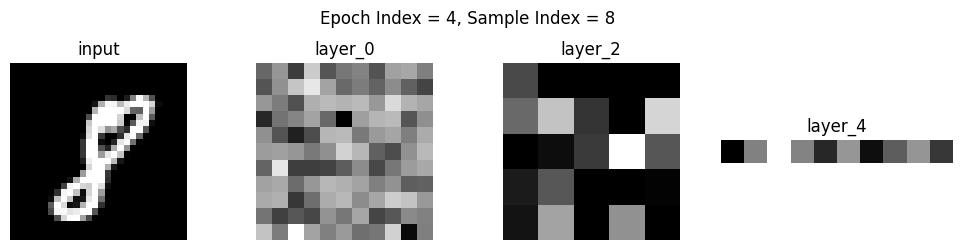

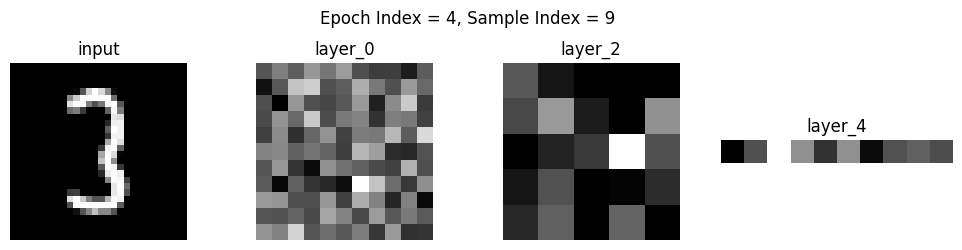

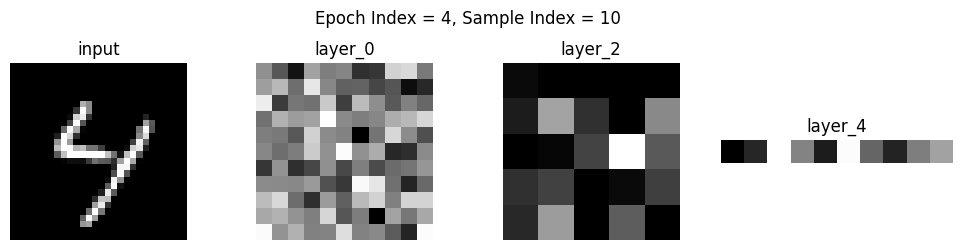

In [226]:
for epoch_idx in range(5):
  for num in range(11):
    show_activation_grid(all_epoch_activations[epoch_idx], num)

Storing in Vector Database (Chroma):

In [229]:
# !pip install chromadb
import chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.2 MB/s et

In [239]:
import chromadb
from chromadb.config import Settings

In [242]:
chroma_client = chromadb.Client(Settings(
    anonymized_telemetry = False
))
collection = chroma_client.get_or_create_collection(name = "neuron_values")

In [243]:
import uuid

In [249]:
# # def store_epoch_in_chromadb(epoch_idx):
# #   epoch_data = all_epoch_activations[epoch_idx]

# #   for layer_name, tensor in epoch_data.items():
# #     tensor = tensor.to(torch.float32).cpu()
# #     embeddings = tensor.tolist()

# #     ids = [f"{layer_name}_e{epoch_idx}_s{i}" for i in range(len(embeddings))]

# #     metadatas = [
# #         {
# #             "epoch" : epoch_idx,
# #             "layer" : layer_name,
# #             "sample_idx" : i
# #         } for i in range(len(embeddings))
# #     ]

# #     collection.add(
# #         embeddings=embeddings,
# #         ids = ids,
# #         metadatas = metadatas
# #     )

# #     print(f"Stored {len(embeddings)} vectors from {layer_name} of epoch {epoch_idx}")

# def store_epoch_in_chromadb(epoch_idx, batch_size=1000):
#     epoch_data = all_epoch_activations[epoch_idx]

#     for layer_name, tensor in epoch_data.items():
#         tensor = tensor.to(torch.float32).cpu()
#         embeddings = tensor.tolist()

#         total = len(embeddings)
#         print(f"\nStoring {total} vectors from {layer_name}...")

#         for i in range(0, total, batch_size):
#             batch_embeddings = embeddings[i:i+batch_size]
#             batch_ids = [f"{layer_name}_e{epoch_idx}_s{j}" for j in range(i, i+len(batch_embeddings))]
#             batch_metadatas = [
#                 {
#                     "epoch": epoch_idx,
#                     "layer": layer_name,
#                     "sample_idx": j
#                 } for j in range(i, i+len(batch_embeddings))
#             ]

#             collection.add(
#                 embeddings=batch_embeddings,
#                 ids=batch_ids,
#                 metadatas=batch_metadatas
#             )

#         print(f"✅ Stored {total} vectors for layer {layer_name}")

layer_collections = {}  # One collection per layer

for layer_name in all_epoch_activations[0].keys():
    layer_collections[layer_name] = chroma_client.get_or_create_collection(name=f"activations_{layer_name}")



def store_epoch_in_chromadb(epoch_idx, batch_size=1000):
    epoch_data = all_epoch_activations[epoch_idx]

    for layer_name, tensor in epoch_data.items():
        tensor = tensor.to(torch.float32).cpu()
        embeddings = tensor.tolist()
        collection = layer_collections[layer_name]

        total = len(embeddings)
        print(f"\nStoring {total} vectors from {layer_name}...")

        for i in range(0, total, batch_size):
            batch_embeddings = embeddings[i:i+batch_size]
            batch_ids = [f"{layer_name}_e{epoch_idx}_s{j}" for j in range(i, i+len(batch_embeddings))]
            batch_metadatas = [
                {
                    "epoch": epoch_idx,
                    "layer": layer_name,
                    "sample_idx": j
                } for j in range(i, i+len(batch_embeddings))
            ]

            collection.add(
                embeddings=batch_embeddings,
                ids=batch_ids,
                metadatas=batch_metadatas
            )

        print(f"✅ Stored {total} vectors for layer {layer_name}")


In [250]:
store_epoch_in_chromadb(0)


Storing 63700 vectors from input...
✅ Stored 63700 vectors for layer input

Storing 63700 vectors from layer_0...
✅ Stored 63700 vectors for layer layer_0

Storing 63700 vectors from layer_2...
✅ Stored 63700 vectors for layer layer_2

Storing 63700 vectors from layer_4...
✅ Stored 63700 vectors for layer layer_4


In [251]:
collections = chroma_client.list_collections()

for col in collections:
    print(f"📁 Collection name: {col.name}")


📁 Collection name: activations_layer_4
📁 Collection name: neuron_values
📁 Collection name: activations_input
📁 Collection name: activations_layer_0
📁 Collection name: activations_layer_2


In [252]:
for col in collections:
    print(f"📁 {col.name} | ID: {col.id} | Metadata: {col.metadata}")


📁 activations_layer_4 | ID: 2a1ac2f3-3fb1-4cca-868d-12c2539c9e74 | Metadata: None
📁 neuron_values | ID: 7463beea-70da-4a97-a8d3-ad509b96bcb0 | Metadata: None
📁 activations_input | ID: 835fa6c8-481b-4034-9045-3df4f3368380 | Metadata: None
📁 activations_layer_0 | ID: eb5c74de-bc51-4281-a3f5-ef06f5f8f46a | Metadata: None
📁 activations_layer_2 | ID: fd69e598-c836-4e26-a893-8d2e08b44995 | Metadata: None


In [258]:
results = collection.get()
print(len(results['embeddings']))  # Total number of vectors


TypeError: object of type 'NoneType' has no len()

In [260]:
results = collection.get()
print(results)  # Check structure


{'ids': ['input_e0_s0', 'input_e0_s1', 'input_e0_s2', 'input_e0_s3', 'input_e0_s4', 'input_e0_s5', 'input_e0_s6', 'input_e0_s7', 'input_e0_s8', 'input_e0_s9', 'input_e0_s10', 'input_e0_s11', 'input_e0_s12', 'input_e0_s13', 'input_e0_s14', 'input_e0_s15', 'input_e0_s16', 'input_e0_s17', 'input_e0_s18', 'input_e0_s19', 'input_e0_s20', 'input_e0_s21', 'input_e0_s22', 'input_e0_s23', 'input_e0_s24', 'input_e0_s25', 'input_e0_s26', 'input_e0_s27', 'input_e0_s28', 'input_e0_s29', 'input_e0_s30', 'input_e0_s31', 'input_e0_s32', 'input_e0_s33', 'input_e0_s34', 'input_e0_s35', 'input_e0_s36', 'input_e0_s37', 'input_e0_s38', 'input_e0_s39', 'input_e0_s40', 'input_e0_s41', 'input_e0_s42', 'input_e0_s43', 'input_e0_s44', 'input_e0_s45', 'input_e0_s46', 'input_e0_s47', 'input_e0_s48', 'input_e0_s49', 'input_e0_s50', 'input_e0_s51', 'input_e0_s52', 'input_e0_s53', 'input_e0_s54', 'input_e0_s55', 'input_e0_s56', 'input_e0_s57', 'input_e0_s58', 'input_e0_s59', 'input_e0_s60', 'input_e0_s61', 'input_e0